<div class="alert alert-info">
<strong>
<h1 style='font-size:22px;text-align: center'>How to plot a RGB image from MODIS MYD021KM products <br> using python, matplotlib and cartopy ?</h1>
</strong>
<br>
<p style='text-align: center'>
Benjamin Marchant 
<br> benjamin.marchant@nasa.gov
<br> marchant.benjamin01@gmail.com
</p>
</div>

Table of Content:

* [Create a RGB image from MODIS MYD021KM products](#rgb_image)
* [Create a RGB image with enhanced colors](#enhanced_colors)
* [Create a RGB image with enhanced colors with orthographic projection](#orthographic_projection)
* [Create MODIS RGB image using IDEAS4EO](#ideas4eo)

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Create a RGB image from MODIS MYD021KM products <a class="anchor" id="rgb_image"></a>

In [2]:
import ideas4eo.config as idea_config 

media_path = idea_config.media_path

print(media_path)

/Users/mb/Desktop/mb_root/files


In [3]:
import ideas4eo.grt.nasa_laads_daac as nasa_laads_daac
import importlib

importlib.reload(nasa_laads_daac)

product = "MYD021KM"
collection = 61
year = 2021
month = 7
day = 22
hour = 13
minute = 0

nasa_laads_daac.get_file(product,collection,year,month,day,hour,minute)

([], 'MYD021KM.A2021203.1300.061.2021204155630.hdf')

In [4]:
import ideas4eo.grt.date_converter as date_converter

count_of_day = date_converter.get_count_of_day(year,month,day)

print(count_of_day)

203


In [5]:
fig_style_dict = {}

fig_style_dict['facecolor'] = 'white'
fig_style_dict['label_font_size'] = 12
fig_style_dict['title_font_size'] = 14
fig_style_dict['heatmap_annot_font_size'] = 14

In [6]:
import glob

files_list = glob.glob( "{}/{}/{}/{}/{}_{}_{}/*".format(media_path,product,collection,year,year,month,day) )

file_name = ''
for file in files_list:
    file_name_prefix = '{}.A{:04d}{:03d}.{:02d}{:02d}'.format(product,year,count_of_day,hour,minute)
    for i in file.split('/')[-1:]:
        if file_name_prefix in i:
            file_name = i  
            
print(file_name)

MYD021KM.A2021203.1300.061.2021204155630.hdf


In [7]:
from pyhdf.SD import SD, SDC 
from pyhdf.HDF import *
from pyhdf.VS import *

import numpy as np

file_dl = '{}/{}/{}/{}/{}_{}_{}/{}'.format(media_path,product,collection,year,year,month,day,file_name)

#print(file_dl)

file = SD(file_dl, SDC.READ)

datasets_dic = file.datasets()

for idx,sds in enumerate(datasets_dic.keys()):
    print(idx,sds)

0 Latitude
1 Longitude
2 EV_1KM_RefSB
3 EV_1KM_RefSB_Uncert_Indexes
4 EV_1KM_Emissive
5 EV_1KM_Emissive_Uncert_Indexes
6 EV_250_Aggr1km_RefSB
7 EV_250_Aggr1km_RefSB_Uncert_Indexes
8 EV_250_Aggr1km_RefSB_Samples_Used
9 EV_500_Aggr1km_RefSB
10 EV_500_Aggr1km_RefSB_Uncert_Indexes
11 EV_500_Aggr1km_RefSB_Samples_Used
12 Height
13 SensorZenith
14 SensorAzimuth
15 Range
16 SolarZenith
17 SolarAzimuth
18 gflags
19 EV_Band26
20 EV_Band26_Uncert_Indexes
21 Band_250M
22 Band_500M
23 Band_1KM_RefSB
24 Band_1KM_Emissive
25 Noise in Thermal Detectors
26 Change in relative responses of thermal detectors
27 DC Restore Change for Thermal Bands
28 DC Restore Change for Reflective 250m Bands
29 DC Restore Change for Reflective 500m Bands
30 DC Restore Change for Reflective 1km Bands


In [8]:
#Cloud_Mask_1km = myd06_l2.myd06_l2(myd06_l2_file,'Cloud_Mask_1km',bit_start=1,bit_count=2,bit=0)

#pprint.pprint( Cloud_Mask_1km.sds_attributes )

#print( Cloud_Mask_1km.data )

In [9]:
selected_sds = file.select('EV_250_Aggr1km_RefSB')
    
selected_sds_attributes = selected_sds.attributes()

for key, value in selected_sds_attributes.items():
    if key == 'reflectance_scales':
        reflectance_scales_250_Aggr1km_RefSB = np.asarray(value)
    if key == 'reflectance_offsets':
        reflectance_offsets_250_Aggr1km_RefSB = np.asarray(value)
        
sds_data_250_Aggr1km_RefSB = selected_sds.get()

In [10]:
selected_sds = file.select('EV_500_Aggr1km_RefSB')

selected_sds_attributes = selected_sds.attributes()

for key, value in selected_sds_attributes.items():
    if key == 'reflectance_scales':
        reflectance_scales_500_Aggr1km_RefSB = np.asarray(value)
    if key == 'reflectance_offsets':
        reflectance_offsets_500_Aggr1km_RefSB = np.asarray(value)

sds_data_500_Aggr1km_RefSB = selected_sds.get()

print( reflectance_scales_500_Aggr1km_RefSB.shape)

data_shape = sds_data_250_Aggr1km_RefSB.shape

(5,)


In [11]:
along_track = data_shape[1]
cross_trak = data_shape[2]

z = np.zeros((along_track, cross_trak,3))

z[:,:,0] = ( sds_data_250_Aggr1km_RefSB[0,:,:] - reflectance_offsets_250_Aggr1km_RefSB[0] ) * reflectance_scales_250_Aggr1km_RefSB[0] 
z[:,:,1] = ( sds_data_500_Aggr1km_RefSB[1,:,:] - reflectance_offsets_500_Aggr1km_RefSB[1] ) * reflectance_scales_500_Aggr1km_RefSB[1] 
z[:,:,2] = ( sds_data_500_Aggr1km_RefSB[0,:,:] - reflectance_offsets_500_Aggr1km_RefSB[0] ) * reflectance_scales_500_Aggr1km_RefSB[0] 

In [12]:
norme = 0.8 # factor to increase the brightness ]0,1]

rgb = np.zeros((along_track, cross_trak,3))

rgb = z / norme

rgb[ rgb > 1 ] = 1.0
rgb[ rgb < 0 ] = 0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


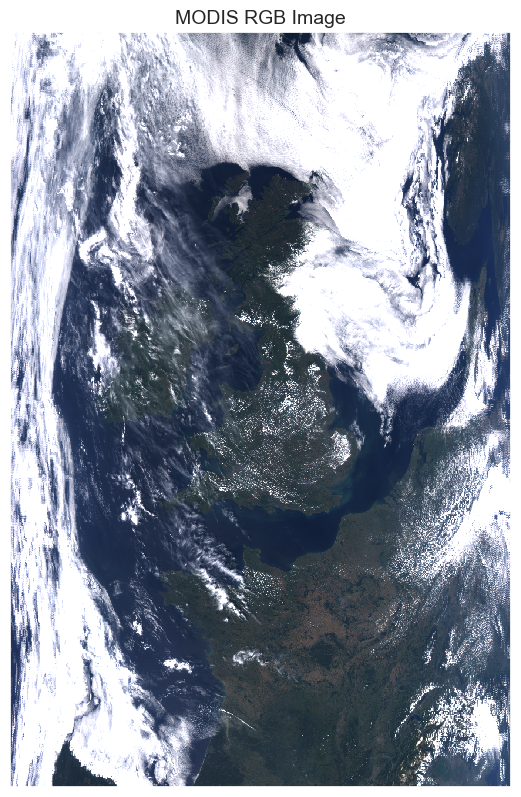

In [13]:
from matplotlib.pyplot import figure

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
import seaborn as sns; sns.set()

fig = figure(num=None, figsize=(12, 10), dpi=100, facecolor=fig_style_dict['facecolor'], edgecolor='k')

ax = fig.add_subplot(111)

img = plt.imshow(np.fliplr(rgb)*2.0, interpolation='nearest', origin='lower')

l = [int(i) for i in np.linspace(0,cross_trak,6)]
plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )

l = [int(i) for i in np.linspace(0,along_track,9)]
plt.yticks(l, l, rotation=0, fontsize=11 )

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.title('MODIS RGB Image', fontsize=14)

plt.grid(None) 

ax.set_yticklabels([])
ax.set_xticklabels([])

#plt.savefig("rgb.png", bbox_inches='tight', facecolor=fig.get_facecolor())

plt.show()

plt.close()

### Create a RGB image with enhanced colors <a class="anchor" id="enhanced_colors"></a>

In [14]:
def bytescale(data, cmin=None, cmax=None, high=255, low=0):
    """
    Byte scales an array (image).

    Byte scaling means converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255).
    If the input image already has dtype uint8, no scaling is done.

    Parameters
    ----------
    data : ndarray
        PIL image data array.
    cmin : scalar, optional
        Bias scaling of small values. Default is ``data.min()``.
    cmax : scalar, optional
        Bias scaling of large values. Default is ``data.max()``.
    high : scalar, optional
        Scale max value to `high`.  Default is 255.
    low : scalar, optional
        Scale min value to `low`.  Default is 0.

    Returns
    -------
    img_array : uint8 ndarray
        The byte-scaled array.

    Examples
    --------
    >>> img = array([[ 91.06794177,   3.39058326,  84.4221549 ],
                     [ 73.88003259,  80.91433048,   4.88878881],
                     [ 51.53875334,  34.45808177,  27.5873488 ]])
    >>> bytescale(img)
    array([[255,   0, 236],
           [205, 225,   4],
           [140,  90,  70]], dtype=uint8)
    >>> bytescale(img, high=200, low=100)
    array([[200, 100, 192],
           [180, 188, 102],
           [155, 135, 128]], dtype=uint8)
    >>> bytescale(img, cmin=0, cmax=255)
    array([[91,  3, 84],
           [74, 81,  5],
           [52, 34, 28]], dtype=uint8)

    """
    if data.dtype == np.uint8:
        return data

    if high < low:
        raise ValueError("`high` should be larger than `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data * 1.0 - cmin) * scale + 0.4999
    bytedata[bytedata > high] = high
    bytedata[bytedata < 0] = 0
    return np.cast[np.uint8](bytedata) + np.cast[np.uint8](low)

In [15]:
x = np.array([0,  30,  60, 120, 190, 255], dtype=np.uint8)
y = np.array([0, 110, 160, 210, 240, 255], dtype=np.uint8)

def scale_image(image, x, y):
    scaled = np.zeros((along_track, cross_trak), dtype=np.uint8)
    for i in range(len(x)-1):
        x1 = x[i]
        x2 = x[i+1]
        y1 = y[i]
        y2 = y[i+1]
        m = (y2 - y1) / float(x2 - x1)
        b = y2 - (m *x2)
        mask = ((image >= x1) & (image < x2))
        scaled = scaled + mask * np.asarray(m * image + b, dtype=np.uint8)

    mask = image >= x2
    scaled = scaled + (mask * 255)

    return scaled

z_color_enh = np.zeros((along_track, cross_trak,3), dtype=np.uint8)

z_color_enh[:,:,0] = scale_image(bytescale(z[:,:,0]), x, y)
z_color_enh[:,:,1] = scale_image(bytescale(z[:,:,1]), x, y)
z_color_enh[:,:,2] = scale_image(bytescale(z[:,:,2]), x, y)

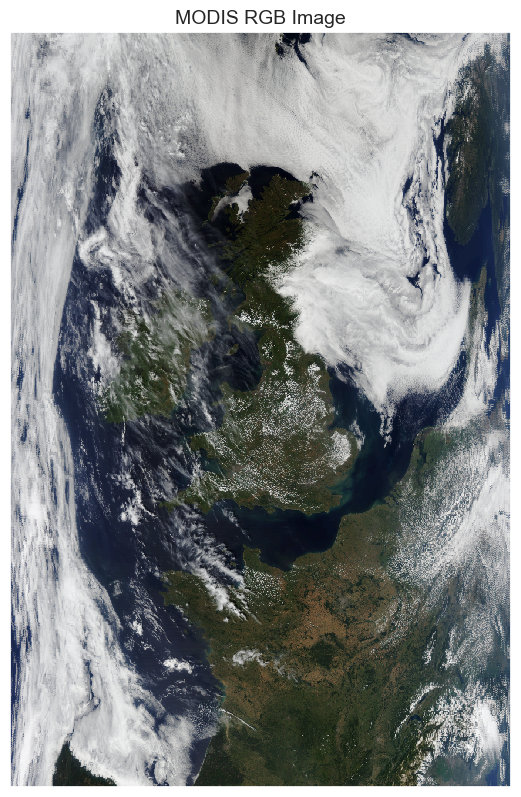

In [16]:
fig = figure(num=None, figsize=(12, 10), dpi=100, facecolor=fig_style_dict['facecolor'], edgecolor='k')

ax = fig.add_subplot(111)

img = plt.imshow(np.fliplr(z_color_enh), interpolation='nearest', origin='lower')

l = [int(i) for i in np.linspace(0,cross_trak,6)]
plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )

l = [int(i) for i in np.linspace(0,along_track,9)]
plt.yticks(l, l, rotation=0, fontsize=11 )

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.title('MODIS RGB Image', fontsize=14)

plt.grid(None) 

ax.set_yticklabels([])
ax.set_xticklabels([])

#plt.savefig("rgb.png", bbox_inches='tight', facecolor=fig.get_facecolor())

plt.show()

plt.close()

### Create a RGB image with enhanced colors with orthographic projection <a class="anchor" id="orthographic_projection"></a>

In [17]:
product = "MYD03"
collection = 61
year = 2021
month = 7
day = 22
hour = 13
minute = 0

nasa_laads_daac.get_file(product,collection,year,month,day,hour,minute)

([], 'MYD03.A2021203.1300.061.2021204152310.hdf')

In [21]:
files_list = glob.glob( "{}/{}/{}/{}/{}_{}_{}/*".format(media_path,product,collection,year,year,month,day) )

myd03_file_name = ''
for file in files_list:
    file_name_prefix = '{}.A{:04d}{:03d}.{:02d}{:02d}'.format(product,year,count_of_day,hour,minute)
    for i in file.split('/')[-1:]:
        if file_name_prefix in i:
            myd03_file_name = i  
            
print(myd03_file_name)

MYD03.A2021203.1300.061.2021204152310.hdf


In [181]:
file_dl = '{}/{}/{}/{}/{}_{}_{}/{}'.format(media_path,product,collection,year,year,month,day,myd03_file_name)

myd03 = SD(file_dl, SDC.READ)

myd03_Latitude = myd03.select('Latitude')
myd03_Longitude = myd03.select('Longitude')

myd03_Latitude_data = myd03_Latitude.get()
myd03_Longitude_data = myd03_Longitude.get()

myd03_Latitude_data = np.fliplr(myd03_Latitude_data)
myd03_Longitude_data = np.fliplr(myd03_Longitude_data)

In [182]:
myd03_Latitude_shape = myd03_Latitude_data.shape

print(myd03_Latitude_shape)

(2040, 1354)


In [183]:
z = z_color_enh / 256.0

z = np.fliplr(z)

In [184]:
print( np.max(z)  )

0.99609375


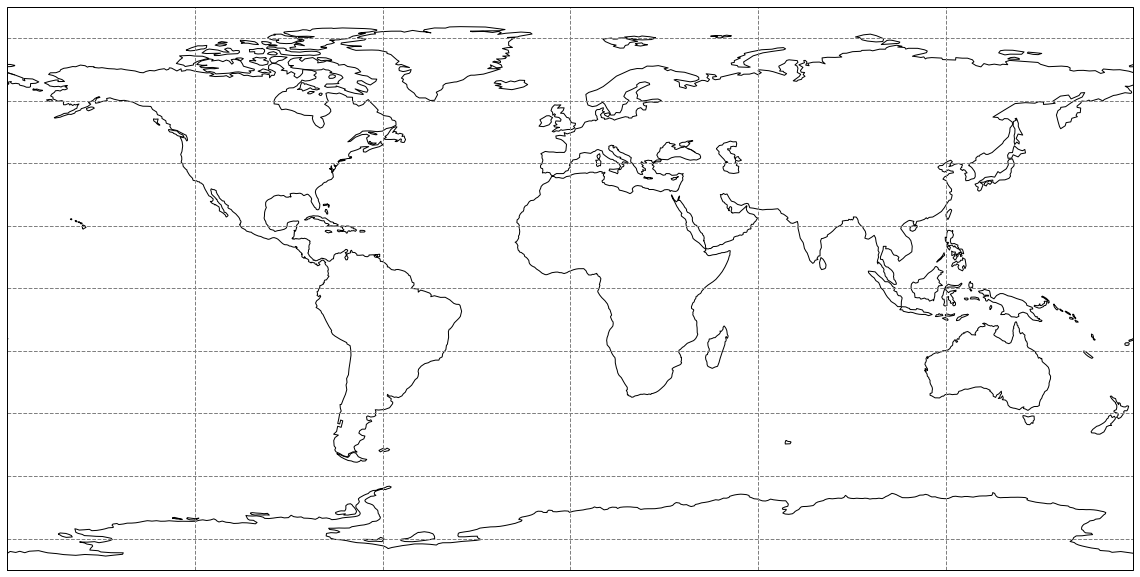

In [185]:
from cartopy import config

import cartopy.crs as ccrs

plt.figure(figsize=(16,9))

proj = ccrs.PlateCarree()

ease_extent = [-180., 180., 90., -90.]

ax = plt.axes(projection=proj)

ax.set_extent(ease_extent, crs=proj) 

ax.gridlines(color='gray', linestyle='--')

ax.coastlines()

plt.tight_layout()

In [186]:
along_track = myd03_Latitude_shape[0]
cross_trak = myd03_Latitude_shape[1]

In [187]:
lat_long_grid = proj.transform_points(                 
                    x = myd03_Longitude_data,
                    y = myd03_Latitude_data,
                    src_crs = proj)

print(lat_long_grid.shape)
print(lat_long_grid)

(2040, 1354, 3)
[[[-12.78686047  41.1125145    0.        ]
  [-12.7334156   41.1280365    0.        ]
  [-12.68035889  41.14341736   0.        ]
  ...
  [ 15.44786358  45.16826248   0.        ]
  [ 15.5096159   45.16886902   0.        ]
  [ 15.5711832   45.16944122   0.        ]]

 [[-12.79544449  41.12940979   0.        ]
  [-12.74196053  41.14488602   0.        ]
  [-12.68886566  41.16021729   0.        ]
  ...
  [ 15.44806194  45.18629456   0.        ]
  [ 15.50920105  45.18695068   0.        ]
  [ 15.57095909  45.18758011   0.        ]]

 [[-12.80404854  41.14630127   0.        ]
  [-12.75052547  41.16172791   0.        ]
  [-12.69739246  41.1770134    0.        ]
  ...
  [ 15.44810486  45.20432281   0.        ]
  [ 15.50926113  45.20503616   0.        ]
  [ 15.5712471   45.20572281   0.        ]]

 ...

 [[-26.66227722  57.19991684   0.        ]
  [-26.59541512  57.2239151    0.        ]
  [-26.52898598  57.24768829   0.        ]
  ...
  [ 14.6782465   63.1764183    0.        ]
  

In [188]:
x_igrid = lat_long_grid[:,:,0] ## long
y_igrid = lat_long_grid[:,:,1] ## lat

x_igrid.shape

(2040, 1354)

In [189]:
print(np.min(myd03_Latitude))
print(np.max(myd03_Latitude))

print(np.min(myd03_Longitude_data))
print(np.max(myd03_Longitude_data))

41.112514
63.235092
-26.69995
15.571513


In [190]:
geod = ccrs.Geodetic()

xul, yul = proj.transform_point(
    x = myd03_Longitude_data[0,0],
    y = myd03_Latitude_data[0,0],
    src_crs = geod)

xlr, ylr = proj.transform_point(
    x = myd03_Longitude_data[myd03_Latitude_shape[0]-1,myd03_Latitude_shape[1]-1],
    y = myd03_Latitude_data[myd03_Latitude_shape[0]-1,myd03_Latitude_shape[1]-1],
    src_crs = geod)

In [191]:
print(xul,xlr,yul,ylr)

-12.786860466003418 14.875434875488281 41.11251449584961 63.208980560302734


In [192]:
xul = np.min(myd03_Longitude_data)
xlr = np.max(myd03_Longitude_data)

yul = np.min(myd03_Latitude)
ylr = np.max(myd03_Latitude)

In [219]:
%%time

from scipy.interpolate import griddata

z_igrid_01 = np.zeros((along_track, cross_trak))
z_igrid_02 = np.zeros((along_track, cross_trak))
z_igrid_03 = np.zeros((along_track, cross_trak))

z_igrid_01[:,:] = z[:,:,0]
z_igrid_02[:,:] = z[:,:,1]
z_igrid_03[:,:] = z[:,:,2]

x1_igrid = x_igrid.ravel()
y1_igrid = y_igrid.ravel()

z_igrid_01 = z_igrid_01.ravel()
z_igrid_02 = z_igrid_02.ravel()
z_igrid_03 = z_igrid_03.ravel()

xy1_igrid = np.vstack((x1_igrid, y1_igrid)).T
xi, yi = np.mgrid[xul:xlr:1000j, yul:ylr:1000j]

z_01 = griddata(xy1_igrid, z_igrid_01, (xi, yi), method='nearest')
z_02 = griddata(xy1_igrid, z_igrid_02, (xi, yi), method='nearest')
z_03 = griddata(xy1_igrid, z_igrid_03, (xi, yi), method='nearest')

CPU times: user 15.2 s, sys: 137 ms, total: 15.4 s
Wall time: 15.4 s


In [220]:
%%time

from scipy.interpolate.interpnd import _ndim_coords_from_arrays
from scipy.spatial import cKDTree

THRESHOLD = 0.2

tree = cKDTree(xy1_igrid)
arr_x = _ndim_coords_from_arrays((xi, yi))
dists, indexes = tree.query(arr_x)

z_01[dists > THRESHOLD] = np.nan
z_02[dists > THRESHOLD] = np.nan
z_03[dists > THRESHOLD] = np.nan

CPU times: user 5.15 s, sys: 39.8 ms, total: 5.19 s
Wall time: 5.21 s


In [221]:
rgb_projected = np.zeros((1000, 1000,3))

rgb_projected[:,:,0] = z_01[:,:]
rgb_projected[:,:,1] = z_02[:,:]
rgb_projected[:,:,2] = z_03[:,:]

rgb_projected.shape

(1000, 1000, 3)

In [222]:
whereAreNaNs = np.isnan(rgb_projected);
rgb_projected[whereAreNaNs] = 0.;

rgb_projected

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [223]:
print( np.max(rgb_projected)  )

0.99609375


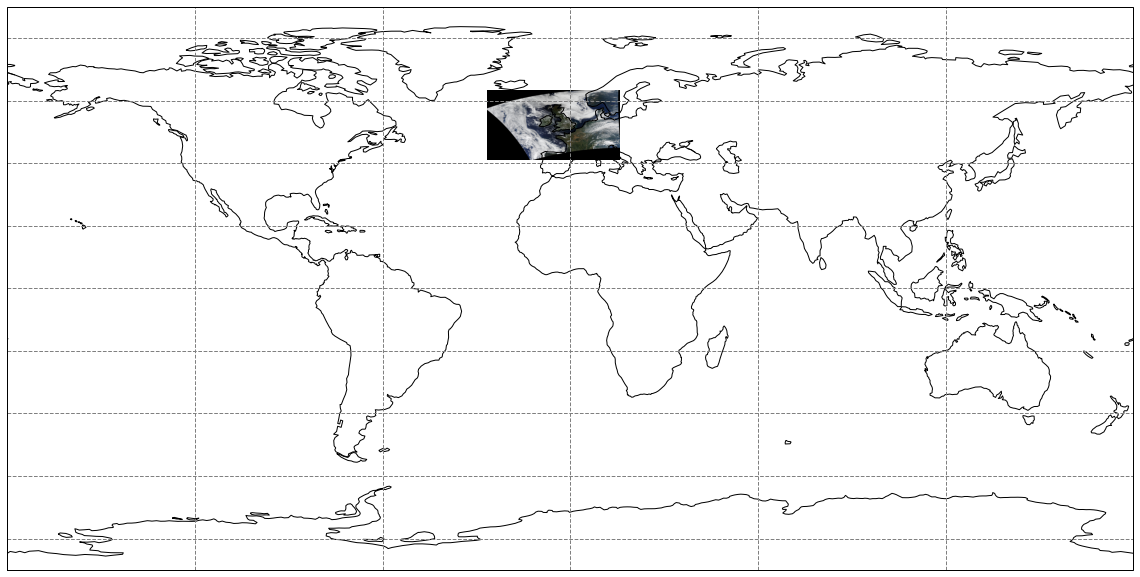

In [224]:
plt.figure(figsize=(16,9))

proj = ccrs.PlateCarree()

ease_extent = [-180., 180., 90., -90.]

ax = plt.axes(projection=proj)

ax.set_extent(ease_extent, crs=proj) 


swe_extent = [xul, xlr, yul, ylr]

ax.imshow(np.rot90(np.fliplr(rgb_projected)), extent=swe_extent, transform=proj, origin='lower')


ax.gridlines(color='gray', linestyle='--')

ax.coastlines()

plt.tight_layout()

In [174]:
min_long = np.min(myd03_Longitude_data)
max_long = np.max(myd03_Longitude_data)

min_lat = np.min(myd03_Latitude)
max_lat = np.max(myd03_Latitude)

/Users/mb/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


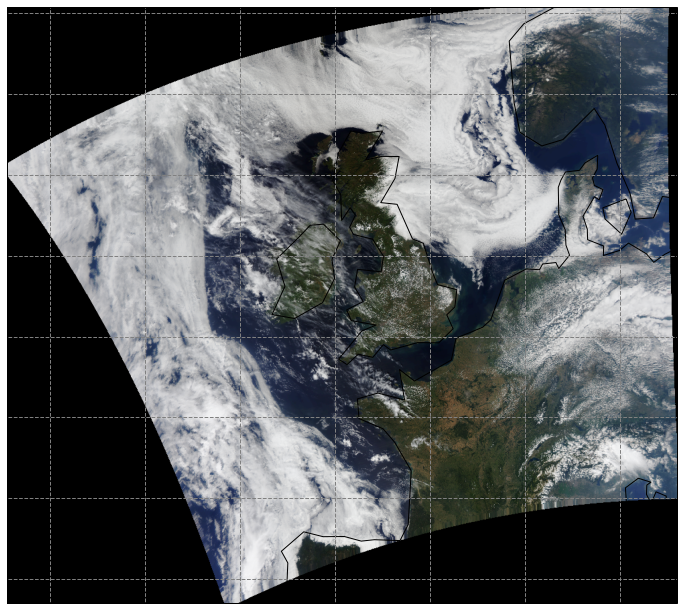

In [235]:
plt.figure(figsize=(12,12))

proj = ccrs.PlateCarree()

offset = 0.0

ease_extent = [min_long-offset, 
               max_long+offset, 
               min_lat-offset, 
               max_lat+offset]

ax = plt.axes(projection=proj)

ax.set_extent(ease_extent, crs=proj) 


swe_extent = [xul, xlr, yul, ylr]

ax.imshow(np.rot90(np.fliplr(rgb_projected)), extent=swe_extent, transform=proj, origin='lower', aspect=1.7)


ax.gridlines(color='gray', linestyle='--')

ax.coastlines()

plt.tight_layout()

### Create MODIS RGB image using IDEAS4EO <a class="anchor" id="ideas4eo"></a>

Setup IDEAS4EO:

Step 1:

Clone the project on your local machine:

[IDEAS4EO GitHub Project](https://github.com/benjamin-hg-marchant/ideas4eo)

Step 2:

Edit the config.json file: enter your NASA laads_daac_token and enter the directory path where the files will be downloaded, for example:

    {
    "nasa_laads_daac_token": "Ym1hcmNoYW50OlltVnVhbUZ0YVc0dWJXRnlZMmhoYm5SQWJtRnpZUzVuYjNZPToxNjI0NzE3MjEwOjEwZmNhNWU4ODVlNzc3OGUyMzE3NzFkZjNmNjUwMGIzNjVhMDY4ZWY",
    "media_path": "/Users/Toto/Desktop/media/files"
    }

Step 3: enter in your terminal:

export PYTHONPATH="/Users/mb/Desktop/mb_root/github"

where /Users/mb/Desktop/mb_root/github is the path to IDEAS4EO module

Step 4: start to use it:

jupyter notebook

In [1]:
import ideas4eo.config as idea_config 

media_path = idea_config.media_path

print(media_path)

/Users/mb/Desktop/mb_root/files


Download MYD021KM and MYD03 Files:

In [2]:
import ideas4eo.grt.nasa_laads_daac as nasa_laads_daac
import importlib

importlib.reload(nasa_laads_daac)

product = "MYD021KM"
collection = 61
year = 2021
month = 7
day = 22
hour = 11
minute = 20

nasa_laads_daac.get_file(product,collection,year,month,day,hour,minute)

product = "MYD03"

nasa_laads_daac.get_file(product,collection,year,month,day,hour,minute)

([], 'MYD03.A2021203.1120.061.2021204154002.hdf')

In [3]:
import ideas4eo.grt.misc as misc
import ideas4eo

importlib.reload(misc)

product = "MYD03"

myd03_file_name = misc.get_filename(media_path,product,collection,year,month,day,hour,minute)

print(myd03_file_name)

product = "MYD021KM"

myd021km_file_name = misc.get_filename(media_path,product,collection,year,month,day,hour,minute)

print(myd021km_file_name)

MYD03.A2021203.1120.061.2021204154002.hdf
MYD021KM.A2021203.1120.061.2021204155645.hdf


In [4]:
from pyhdf.SD import SD, SDC 
from pyhdf.HDF import *
from pyhdf.VS import *

product = "MYD03"
file_dl = '{}/{}/{}/{}/{}_{}_{}/{}'.format(media_path,product,collection,year,year,month,day,myd03_file_name)
myd03_file_name = SD(file_dl, SDC.READ)

product = "MYD021KM"
file_dl = '{}/{}/{}/{}/{}_{}_{}/{}'.format(media_path,product,collection,year,year,month,day,myd021km_file_name)
myd021km_file = SD(file_dl, SDC.READ)

(5,)


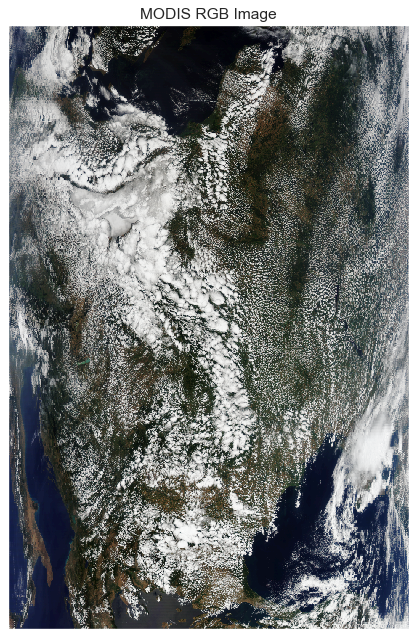

In [13]:
import ideas4eo.viz.modis_rgb as modis_rgb

importlib.reload(modis_rgb)

rgb = modis_rgb.plot_modis_rgb_image(myd021km_file)

(5,)


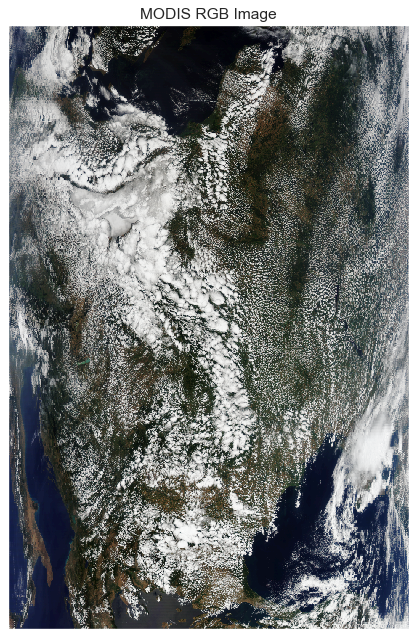

/Users/mb/Desktop/mb_root/github/ideas4eo/viz/modis_rgb.py:253: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


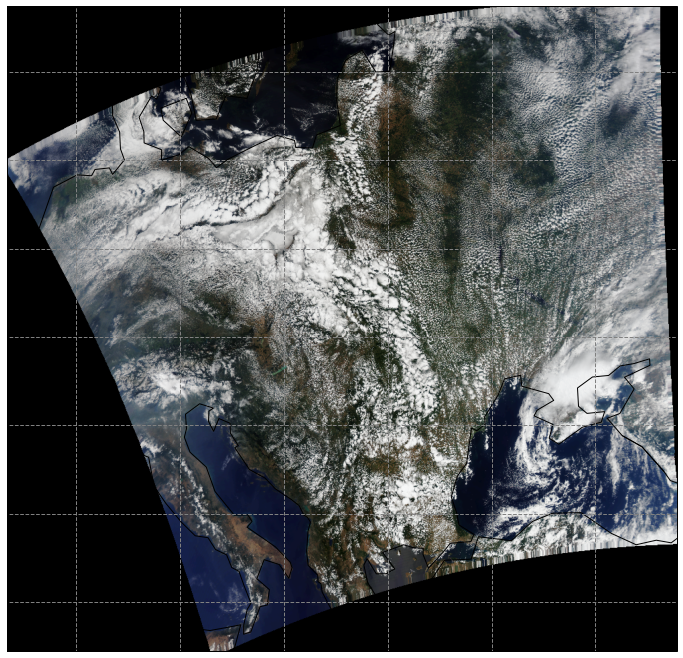

In [18]:
import ideas4eo.viz.modis_rgb as modis_rgb

importlib.reload(modis_rgb)

rgb_projected = modis_rgb.plot_modis_rgb_image_with_orthographic_projection(myd021km_file, myd03_file_name)